#Fake News detection

In [2]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')

ModuleNotFoundError: No module named 'seaborn'

###Load Dataset

In [ ]:
df_true = pd.read_csv('data/True.csv')
df_fake = pd.read_csv('data/Fake.csv')
df_true.shape, df_fake.shape

FileNotFoundError: [Errno 2] No such file or directory: 'True.csv'

###Drop columns "subject" and "subject". Add column "label"

In [18]:
df_true.drop(['subject', 'date'], axis=1, inplace=True)
df_fake.drop(['subject', 'date'], axis=1, inplace=True)
df_true['label'] = 1
df_fake['label'] = 0
df_true.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


###Merge True and Fake dataset

In [19]:
df = pd.concat([df_true,df_fake]).sample(frac=1).reset_index(drop=True)
df.head()

,title,text,label
0,"Trump taps Pence to lead transition team, remo...",WASHINGTON (Reuters) - Republican U.S. Preside...,1
1,Bernie Sanders brings local politics focus to ...,"SOMERVILLE, Mass. (Reuters) - U.S. Senator Ber...",1
2,House speaker: May need a temporary bill to fu...,WASHINGTON (Reuters) - U.S. lawmakers may have...,1
3,China calls for restraint after a U.S. B-1B bo...,BEIJING (Reuters) - China said on Wednesday it...,1
4,Teen ‘Accidentally’ Shot And Killed By His Fa...,"On July 3, William Brumby accidentally shot ...",0


In [23]:
df.shape

(44898, 3)

###Data preprocessing

In [24]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)
df['text'] = df['text'].apply(preprocess_text)

###Feature Extraction

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['label']

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model training

In [27]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
# Predict on the test set
y_pred = model.predict(X_test)
print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Logistic Regression Performance:
Accuracy: 0.9866

Classification Report:
              precision    recall  f1-score   support

           0     0.9897    0.9846    0.9871      4677
           1     0.9834    0.9888    0.9861      4303

    accuracy                         0.9866      8980
   macro avg     0.9865    0.9867    0.9866      8980
weighted avg     0.9867    0.9866    0.9866      8980



In [28]:
with open('model_input.dat', 'wb') as f:
    pickle.dump(model, f)

with open('vector_input.dat', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

###Deploy

In [29]:
def detectNews(text):
    with open('model_input.dat', 'rb') as f:
        model = pickle.load(f)
        
    with open('vector_input.dat', 'rb') as f:
        vectorizer = pickle.load(f)

    """Classify news text as Real or Fake."""
    processed_text = preprocess_text(text)
    text_vector = vectorizer.transform([processed_text])
    prediction = model.predict(text_vector)
    probability = model.predict_proba(text_vector)

    label = "Real News" if prediction[0] == 1 else "Fake News"
    confidence = probability[0][prediction[0]]

    return label, confidence

In [30]:

sample_text = "hello world"
result, confidence = detectNews(sample_text)
print(f"Result: {result} with confidence: {confidence:.2f}")

Result: Fake News with confidence: 0.96


###Check for null values

In [12]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

###Check for duplicated values

In [13]:
df.duplicated().sum()

np.int64(5921)

In [14]:
df.drop_duplicates(inplace=True)

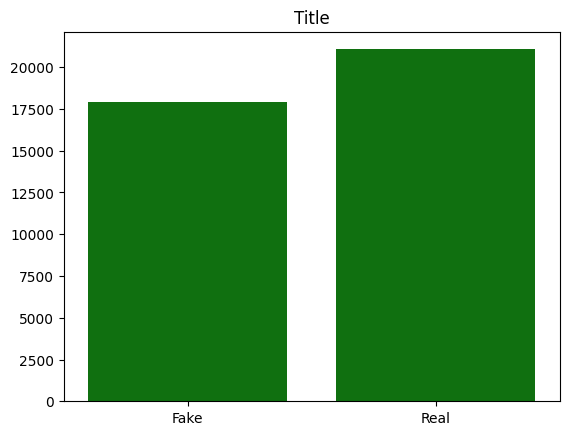

In [15]:
sns.countplot(x='label', data=df, color='g')
plt.title("Title")
plt.xlabel("")
plt.ylabel("")
plt.xticks([1,0], ['Real', 'Fake'])
plt.show()

#References:
1. https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data
